# Results for the rot90 final experiment

In this experiment, we always use fold 0 as test fold and (1,2) as train. We ran each experiment 10 times on each of the two sets of labels we have.

In [1]:
import sys
sys.path.append('..')
import os
import random
import collections
import numpy as np
import unidecode
import numpy.ma as ma
import pylab as pl
import skimage
import pandas as pd
import agronn.classif2 as classif2
import agronn.utils as utils
import agronn.colormaps as colormaps
import matplotlib.cm as cm
import seaborn as sns
import skimage.color as skcolor
import sklearn.cross_validation as skcross
import sklearn.metrics as skmetrics
import scipy.stats as stats
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = filter(lambda l: not len(l.strip()) == 0, lines)

    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[0] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

In [3]:
id2label = np.load('../../results/_meta/id2label.npy')

In [4]:
from collections import defaultdict, OrderedDict
RESDIR = '../../results/rot90_final'

dirs = [d for d in os.listdir(RESDIR)]
print dirs
logs = OrderedDict()

for d in dirs:
    parts = d.split('_')
    ds = parts[1]
    test_fold = parts[4]
    rep = parts[6]
    log = utils.pickle_load(os.path.join(RESDIR, d, 'log.pickle'))
    
    dsnames = {'4':'exp0', '6':'exp1'}
    if rep not in logs:
        logs[rep] = {}
    for mname in ['cnn', 'histnn', 'merged']:
        logs[rep]['%s_%s' % (mname, dsnames[ds])] = log[mname]

['labels_6_test_fold_0_rep_8_gpu0_2015_11_18_02_17_45_epochs_60_60_60', 'labels_4_test_fold_0_rep_6_gpu0_2015_11_16_22_07_58_epochs_60_60_60', 'labels_4_test_fold_0_rep_4_gpu0_2015_11_16_18_10_29_epochs_60_60_60', 'labels_4_test_fold_0_rep_5_gpu0_2015_11_16_20_09_20_epochs_60_60_60', 'labels_4_test_fold_0_rep_9_gpu0_2015_11_17_04_04_03_epochs_60_60_60', 'labels_4_test_fold_0_rep_3_gpu0_2015_11_16_16_11_47_epochs_60_60_60', 'labels_6_test_fold_0_rep_4_gpu0_2015_11_17_18_22_29_epochs_60_60_60', 'labels_6_test_fold_0_rep_1_gpu0_2015_11_17_12_25_47_epochs_60_60_60', 'labels_6_test_fold_0_rep_3_gpu0_2015_11_17_16_23_19_epochs_60_60_60', 'labels_6_test_fold_0_rep_6_gpu0_2015_11_17_22_19_51_epochs_60_60_60', 'labels_4_test_fold_0_rep_8_gpu0_2015_11_17_02_05_19_epochs_60_60_60', 'labels_6_test_fold_0_rep_5_gpu0_2015_11_17_20_21_08_epochs_60_60_60', 'labels_4_test_fold_0_rep_2_gpu0_2015_11_16_14_13_14_epochs_60_60_60', 'labels_4_test_fold_0_rep_7_gpu0_2015_11_17_00_06_29_epochs_60_60_60', 'labe

In [5]:
l = logs['0']
l.keys()

['histnn_exp0',
 'merged_exp1',
 'histnn_exp1',
 'merged_exp0',
 'cnn_exp1',
 'cnn_exp0']

In [6]:
def per_class_fscore(rep, mname):
    model_log = logs[str(rep)][mname]['eval']
    nclasses = len(id2label)
    y_true = model_log['y_test_true']
    y_pred = model_log['y_test_pred']
    
    return skmetrics.f1_score(y_true, y_pred, average=None)

models = ['cnn_exp0', 'histnn_exp0', 'merged_exp0',
          'cnn_exp1', 'histnn_exp1', 'merged_exp1']
scores = []
for mname in models:
    ms = []
    for rep in xrange(10):
        ms.append(per_class_fscore(rep, mname))
    scores.append(ms)
scores = np.array(scores)
print scores.shape
# This is 3x10x23 (nmodels x nreps x nclasses)

(6, 10, 23)


# Averaging over all classes

In [7]:
import matplotlib

matplotlib.rcParams.update({
    'font.size': 13,
    'axes.titlesize' : 14,
    'xtick.labelsize' : 12,
    'ytick.labelsize' : 12
})

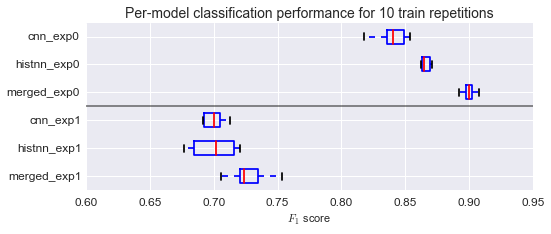

In [8]:
arr = scores.mean(axis=2)

if False:
    models1 = ['cnn_exp0', 'histnn_exp0', 'merged_exp0']
    models2 = ['cnn_exp1', 'histnn_exp1', 'merged_exp1']

    pl.figure(figsize=(8, 4))
    ax = pl.subplot(121)
    _ = ax.boxplot(arr[:3].T, notch=False)
    _ = pl.xticks(1 + np.arange(len(models1)), models1, rotation='vertical')
    pl.ylim((0.8, 1))

    ax = pl.subplot(122)
    _ = ax.boxplot(arr[3:].T, notch=False)
    _ = pl.xticks(1 + np.arange(len(models2)), models2, rotation='vertical')
    pl.ylim((0.6, 0.8))
else:
    pl.figure(figsize=(8, 3))
    pl.title('Per-model classification performance for 10 train repetitions')
    pl.boxplot(arr.T, notch=False, vert=False)
    pl.yticks(1 + np.arange(len(models)), models, rotation='horizontal')
    pl.gca().invert_yaxis()
    pl.xlim((0.6, 0.95))
    pl.axhline(3.5, c='k', alpha=0.5)
    pl.xlabel('$F_1$ score')

if True:
    pl.savefig('../../latex/figs/results_per_model_avg_class_boxplot_test.pdf', bbox_inches='tight', dpi=150)

In [ ]:
import matplotlib

matplotlib.rcParams.update({
    'font.size': 13,
    'axes.titlesize' : 18,
    'xtick.labelsize' : 15,
    'ytick.labelsize' : 15
})

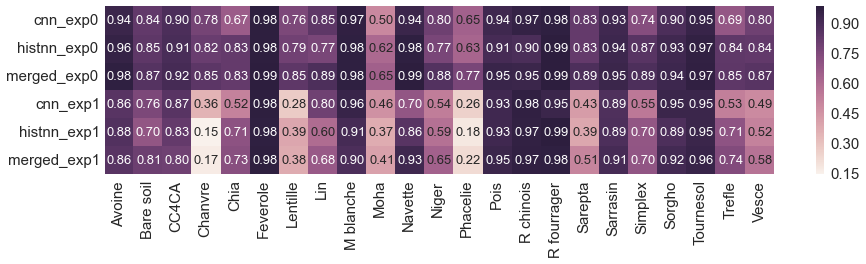

In [18]:
arr = scores.mean(axis=1)

#pl.figure(figsize=(4, 10))
#ax = sns.heatmap(arr.T, annot=True, fmt=".2f", xticklabels=models,
#                 yticklabels=id2label, linewidths=0, rasterized=True)
pl.figure(figsize=(15, 3))
ax = sns.heatmap(arr, annot=True, fmt=".2f", xticklabels=id2label,
                 yticklabels=models, linewidths=0, rasterized=True)

pl.savefig('../../latex/figs/results_per_model_per_class_fscore.pdf',
           bbox_inches='tight', dpi=150)

# ---- Other plots

## per-class boxplot for each model

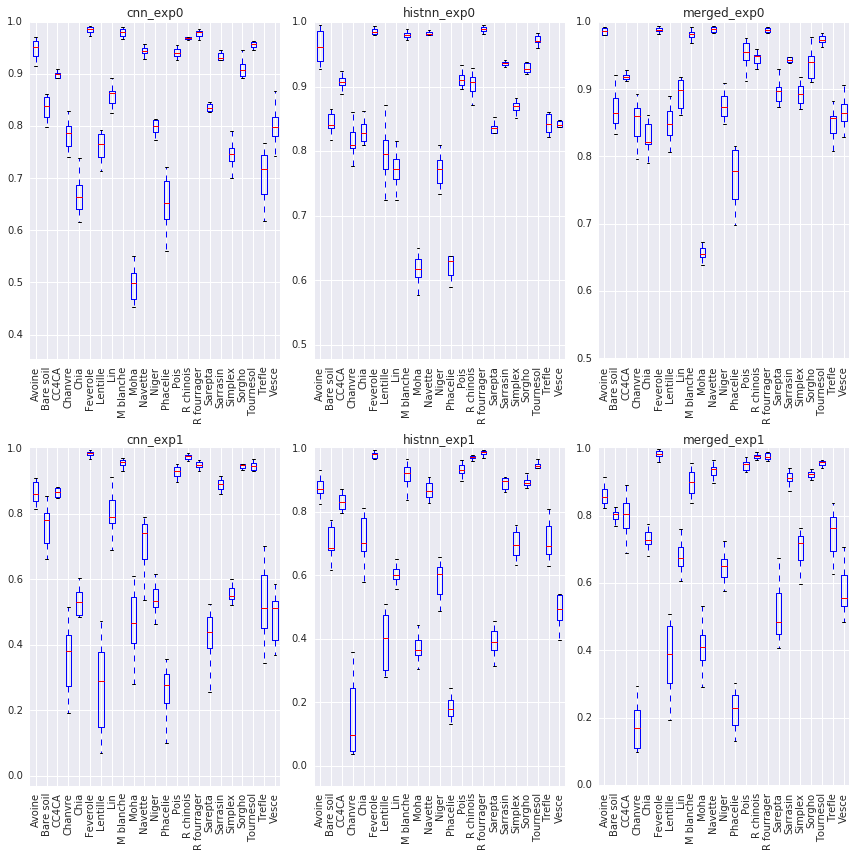

In [9]:
pl.figure(figsize=(12, 12))
for i in xrange(len(models)):
    mname = models[i]
    ax = pl.subplot(2, 3, i + 1)
    ax.set_title(mname)
    arr = scores[i]
    _ = pl.boxplot(arr)
    _ = pl.xticks(1 + np.arange(len(id2label)), id2label, rotation='vertical')
    pl.ylim((arr.min() - 0.1, 1))
pl.tight_layout()

## confmats

In [10]:
import seaborn as sns
import sklearn.metrics as skmetrics

def compute_scores(rep, mname):
    model_log = logs[str(rep)][mname]['eval']
    nclasses = len(id2label)
    y_true = model_log['y_test_true']
    y_pred = model_log['y_test_pred']
    
    print '--- %s %s' % (mname, rep)
    print 'kappa : %f' % utils.kappa(y_true, y_pred)
    print 'accuracy : %f' % skmetrics.accuracy_score(y_true, y_pred)
    print 'global f1 : %f' % skmetrics.f1_score(y_true, y_pred, average='macro')
    print skmetrics.classification_report(y_true, y_pred, labels=np.arange(nclasses),
                                         target_names=id2label)

def plot_confmat_for(rep, mname, ax=None):
    model_log = logs[str(rep)][mname]['eval']
    nclasses = len(id2label)
    y_true = model_log['y_test_true']
    y_pred = model_log['y_test_pred']
    
    confmat = skmetrics.confusion_matrix(y_true, y_pred, labels=np.arange(nclasses))
    
    # actual plot
    ax = sns.heatmap(confmat, annot=True, fmt="d", xticklabels=id2label,
                     square=True, cbar_kws={'shrink':0.8}, linewidths=1,
                     yticklabels=id2label, ax=ax, vmin=0)
    #ax.xaxis.set_label_position('top')
    #ax.xaxis.tick_top()
    #ax.xaxis.get_ticklabels()
    #ax.xaxis.set_tick_params(direction='vertical')
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')

In [11]:
if False:
    for mname in models:
        pl.figure(figsize=(12, 12))
        ax = pl.subplot(111)
        ax.set_title(mname)
        plot_confmat_for(0, mname, ax=ax)
        pl.savefig('../../latex/figs/confmats/%s.pdf' % mname)

## Averaging over all repetitions

(0.050792296985820939, 1)

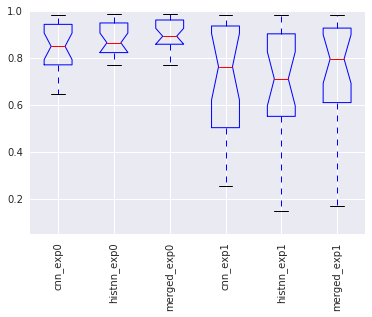

In [12]:
arr = scores.mean(axis=1)

_ = pl.boxplot(arr.T, notch=True)
_ = pl.xticks(1 + np.arange(len(models)), models, rotation='vertical')
pl.ylim((arr.min() - 0.1, 1))

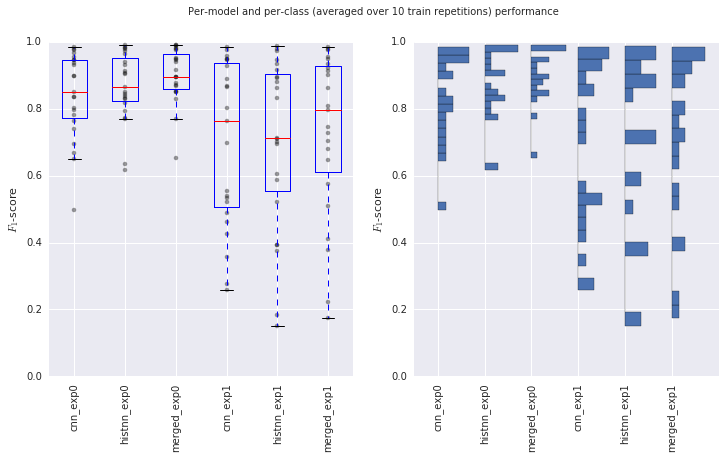

In [13]:
pl.figure(figsize=(12, 6))
pl.suptitle('Per-model and per-class (averaged over 10 train repetitions) performance')
pl.subplot(121)
_ = pl.boxplot(arr.T, notch=False)
_ = pl.xticks(1 + np.arange(len(models)), models, rotation='vertical')

for i, mname in enumerate(models):
    #pl.scatter([i] * arr.shape[1], arr[i], c=np.arange(len(classes)), cmap=cm.Paired, linewidth=0)
    pl.scatter([1 + i] * arr.shape[1], arr[i], c='k', alpha=0.4, linewidth=0)

pl.ylim((0, 1))
pl.ylabel('$F_1$-score')

pl.subplot(122)
for i, mname in enumerate(models):
    hist, edges = np.histogram(arr[i], bins=20)
    #pl.bar(left=edges[:-1], width=edges[1:]-edges[:-1], height=hist / 23., bottom=i, alpha=0.3)
    pl.barh(left=1 + i, height=edges[1:]-edges[:-1],
            width=hist / float(hist.max() + 2),
            bottom=edges[:-1], alpha=1)
    #pl.xlim((0.4, 1))
_ = pl.xticks(1 + np.arange(len(models)), models, rotation='vertical')
#pl.xlim((0, 0.5 + arr.shape[0]))
pl.ylabel('$F_1$-score')
pl.xlim((0.5, pl.xlim()[1]))
pl.ylim((0, 1))
if False:
    pl.savefig('../../latex/figs/results_per_model_avg_rep_boxplot_test.pdf', bbox_inches='tight', dpi=150)